# COMP 551 — Assignment 1

Authors:
 - Bernier, Audréanne
 - Coull-Neveu, Ben
 - Trachsel-Bourbeau, Anjara



Imports

In [88]:
from ucimlrepo import fetch_ucirepo
import numpy as np
import pandas as pd
import seaborn as sns
from math import factorial
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## Functions & Models

### Useful Functions

In [141]:
# Defining minmaxnorm and znorm
def minmaxnorm_series(ser:pd.Series):
  return (ser - ser.min()) / (ser.max() - ser.min())

def znorm_series(ser:pd.Series):
  return (ser - ser.mean()) / ser.std()

def minmaxnorm(df, excl_cols=[]):
  df1 = df.copy()
  for col in df1.columns:
    if col in df1.columns:
      continue
    df1[col] = minmaxnorm_series(df1[col])
  return df1

def znorm(df, excl_cols=[]):
  df1 = df.copy()
  for col in df1.columns:
    if col in excl_cols:
      continue
    df1[col] = znorm_series(df1[col])
  return df1


# Functions to calculate metrics
def root_mean_squared_error(y, yhat):
   
   return np.sqrt(np.mean((y - yhat)**2))

def mean_absolute_error(y, yhat):
  return np.mean(np.abs(y - yhat))

def r2_score(y, yhat):
  return 1 - np.sum((y - yhat)**2) / np.sum((y - np.mean(y))**2)

def report_metrics(y, yhat):
  print("RMSE:", root_mean_squared_error(y, yhat))
  print("MAE:", mean_absolute_error(y, yhat))
  print("R^2:", r2_score(y, yhat))

def compute_test_loss(ytrue_test, yhat_test, model):
    if model == 'linear':
        # L2 loss
        return np.mean((ytrue_test - yhat_test)**2)
    elif model == 'logistic':
        # cross-entropy loss using true labels y_test and predicted probabilities yhat_test
        return -(1/len(ytrue_test)) * np.sum(ytrue_test * np.log(yhat_test) + (1-ytrue_test) * np.log(1-yhat_test))
    else: 
       return None

def store_lin_metrics(df, rowname, ytrain, yhattrain, ytest, yhattest, test_split, 
                      train_split=None, iteration=None, num_batches=None, train_loss=None, 
                      total_epochs=None, model=None, learning_rate=None):
    """
    Add the input metrix to the dataframe and return the updated dataframe.
    """
    metrics = {
      "method": rowname,
      "train_RMSE": root_mean_squared_error(ytrain, yhattrain),
      "train_MAE": mean_absolute_error(ytrain, yhattrain),
      "train_R2": r2_score(ytrain, yhattrain),
      "test_RMSE": root_mean_squared_error(ytest, yhattest),
      "test_MAE": mean_absolute_error(ytest, yhattest),
      "test_R2": r2_score(ytest, yhattest),
      "test_split": round(test_split, 1),
      "train_split": 1-test_split if train_split is None else train_split,
      "test_loss": compute_test_loss(ytest, yhattest, model),
      "train_loss": train_loss,
      "iteration": iteration,
      "num_batches": num_batches,
      "learning_rate": learning_rate,
      "total_epochs": total_epochs
    }

    return pd.concat([df, pd.DataFrame([metrics])], ignore_index=True)

def accuracy(y, yh):
    yh_class = np.where(yh >= 0.5, 1, 0)
    return np.mean(y == yh_class)

def store_logist_metrics(df, rowname, ytrain, yhattrain, ytest, yhattest, test_split, 
                         train_loss=None, iteration=None, model=None, learning_rate=None,
                         total_epochs=None, train_split=None, num_batches=None):
  metrics = {
      "method": rowname,
      "train_accuracy": accuracy(ytrain, yhattrain),
      "test_accuracy": accuracy(ytest, yhattest),
      "test_split": round(test_split, 1),
      "train_split": 1-test_split if train_split is None else train_split,
      "test_R2": r2_score(ytest, yhattest),
      "train_R2": r2_score(ytrain, yhattrain),
      "test_loss": compute_test_loss(ytest, yhattest, model),
      "train_loss": train_loss,
      "iteration": iteration,
      "learning_rate": learning_rate,
      "total_epochs": total_epochs,
      "num_batches": num_batches,
  }
  return pd.concat([df, pd.DataFrame([metrics])], ignore_index=True)


# function to remove outliers
def remove_outliers(df_in, z_threshold=3, excl_cols=[]):
  df = df_in.copy()
  print("========= REMOVING OUTLIERS =========")
  print(f"BEFORE -> N_data = {df.shape[0]}")
  for col in df.columns:
    if col in excl_cols:
      continue
    colmean = df[col].mean()
    colstd = df[col].std()
    uplim = colmean + 3*colstd # above 3 stdev
    lowlim = colmean - 3*colstd # below 3 stdev

    # removing rows with outliers
    df = df[(df[col] < uplim) & (df[col] > lowlim)]

  print(f"AFTER  -> N_data = {df.shape[0]}")
  print("=====================================")

  return df.reset_index(drop=True)


# plotting loss and weights over time
def plot_history(optimizer, ax=None):
  xs = np.arange(len(optimizer.loss_history))

  if ax is None:
      fig, ax = plt.subplots(figsize=(10,6))


  # plot loss
  ax.plot(xs, optimizer.loss_history, color='b', label='Loss')
  ax.set_xlabel('Epoch', fontsize=12)
  ax.set_ylabel('Loss', fontsize=12, color='b')
  ax.tick_params(axis='y', labelcolor='b')

  ax1 = ax.twinx()
  ax1.set_ylabel('Weights', fontsize=12, color='r')
  ax1.tick_params(axis='y', labelcolor='r')
  for i in range(len(optimizer.w_history[0])):
      ax1.plot(xs, optimizer.w_history[:, i], label=f'w{i}', alpha=0.7)

  ax1.legend(loc='upper right', fontsize=10, ncols=3)
  ax.legend(loc='upper left', fontsize=10)
  if ax is None:
      plt.show()
  else:
    return ax1

### Model Implementations

#### Linear Regression

In [90]:
class LinearRegression:
    def __init__(self, add_bias=True):
        self.add_bias = add_bias
        self.N= None # init N
        self.w = None # init w
        self.num_batches = None # batches for gradient descent
        self.loss = None
        self.loss_history = []
        self.w_history = []
        self.grad_history = []
        self.total_epochs = None

    @staticmethod
    def l2_loss(x, y, w):
      return np.mean((y - (x @ w))**2)

    def fit_analytical(self, x, y):
        """
        Fit the model using the analytical solution.
        """
        # Check shape of x
        if x.ndim == 1:
            x = x[:, None]  # add a dimension for the features
        N = x.shape[0]

        # Add bias term if needed
        if self.add_bias:
            x = np.column_stack([x,np.ones(N)])

        # Analytical weight solution using least squares
        self.w = np.linalg.lstsq(x, y)[0]

        # calculate loss for comparisons
        self.loss = LinearRegression.l2_loss(x, y, self.w)
        return self


    def fit_gd_minibatch(self, x, y, optimizer, num_batches=8):
        """
        Fit the model using mini-batch gradient descent.
        """
        # Check shape of x
        if x.ndim == 1:
            x = x[:, None]

        self.num_batches = num_batches

        # Add bias term if needed
        if self.add_bias:
            N = x.shape[0]
            x = np.column_stack([x,np.ones(N)])
        N,D = x.shape

        # Define the gradient function
        def gradient(x, y, w):
            N_batch = x.shape[0]  # batch size
            yh = x @ w
            # grad = (x.T @ (yh - y)) / N_batch
            grad = np.dot(x.T, yh - y)/N_batch
            return grad

        # Run mini-batch GD
        w0 = np.zeros(D)  # initialize the weights to 0
        self.w = optimizer.run_minibatch(gradient,
                                         LinearRegression.l2_loss,
                                         x, y, w0,
                                         self.num_batches
                                         )  # run the optimizer to get the optimal weights

        self.loss = LinearRegression.l2_loss(x, y, self.w)
        self.loss_history = optimizer.loss_history
        self.w_history = optimizer.w_history
        self.grad_history = optimizer.grad_history
        self.total_epochs = optimizer.total_epochs
        return self


    def predict(self, x):
        N = x.shape[0]
        if self.add_bias:
            x = np.column_stack([x,np.ones(N)])
        yh = x@self.w  # predict the y values
        return yh


    def __str__(self):
        return f'weights: {self.w}'

#### Logistic Regression

In [91]:
class LogisticRegression:
    def __init__(self, add_bias=True, verbose=False):
        self.add_bias = add_bias
        self.verbose = verbose
        self.w = None  # weights will be initialized during fitting
        self.loss = None
        self.num_batches = None
        self.total_epochs = None

    # Define the logistic function
    @staticmethod
    def logistic(z):
        z = np.clip(z, -500, 500) # to avoid overflow
        return 1. / (1 + np.exp(-z))

    # Define the gradient function
    @staticmethod
    def gradient(x, y, w):
        N_batch, D = x.shape
        yh = LogisticRegression.logistic(np.dot(x, w))  # predictions size
        # if yh.ndim == 1:
        #     yh = yh[:, None]
        grad = np.dot(x.T, yh - y)/N_batch
        return grad  # size D

    # loss function
    @staticmethod
    def logistic_loss(x, y, w):
      y_pred = LogisticRegression.logistic(np.dot(x,w))
      return -(1/len(y)) * np.sum(y * np.log(y_pred) + (1-y) * np.log(1-y_pred))

    def fit_gd_fullbatch(self, x, y, optimizer):
        """
        Fit the model using full-batch gradient descent.
        """
        # Check shape of x
        if x.ndim == 1:
            x = x[:, None]

        # Add bias term if needed
        if self.add_bias:
            N = x.shape[0]
            x = np.column_stack([x,np.ones(N)])
        N,D = x.shape

        # Run mini-batch GD
        w0 = np.zeros(D)  # initialize the weights to 0
        self.w = optimizer.run_fullbatch(LogisticRegression.gradient, LogisticRegression.logistic_loss, x, y, w0)  # run the optimizer to get the optimal weights
        self.loss = LogisticRegression.logistic_loss(x, y, self.w)
        return self


    def fit_gd_minibatch(self, x, y, optimizer, num_batches=8):
        """
        Fit the model using mini-batch gradient descent.
        """
        # Check shape of x
        if x.ndim == 1:
            x = x[:, None]

        self.num_batches = num_batches

        # Add bias term if needed
        if self.add_bias:
            N = x.shape[0]
            x = np.column_stack([x,np.ones(N)])
        N,D = x.shape

        # Run mini-batch GD
        w0 = np.zeros(D)  # initialize the weights to 0
        self.w = optimizer.run_minibatch(LogisticRegression.gradient, LogisticRegression.logistic_loss, x, y, w0, self.num_batches)  # run the optimizer to get the optimal weights
        self.loss = LogisticRegression.logistic_loss(x, y, self.w)
        self.total_epochs = optimizer.total_epochs
        return self


    def predict(self, x):
        if x.ndim == 1:
            x = x[:, None]
        Nt = x.shape[0]
        if self.add_bias:
            x = np.column_stack([x,np.ones(Nt)])
        yh = self.logistic(np.dot(x,self.w))  # predict output
        return yh

    def __str__(self):
        return f'weights: {self.w}'

#### Gradient descent

In [92]:
class GradientDescent:
    def __init__(self, learning_rate=.001, max_iters=1e4, epsilon=1e-6, min_delta_loss=1e-6, record_history=False):
        self.learning_rate = learning_rate
        self.max_iters = max_iters
        self.record_history = record_history
        self.epsilon = epsilon
        self.w_history = []  # to store the weight history for visualization
        self.loss_history = []  # to store the loss history for visualization
        self.grad_history = []
        self.min_delta_loss = min_delta_loss
        self.total_epochs = 0

    def run_fullbatch(self, gradient_fn, loss_fn, x, y, w):
        """
        Run gradient descent using the full batch.
        """
        grad = np.inf
        t = 1
        prev_loss = np.inf

        # loop and check the loss function
        while np.linalg.norm(grad) > self.epsilon and t < self.max_iters and np.abs(prev_loss - loss_fn(x, y, w)) > self.min_delta_loss: # Added last check for loss stability
            prev_loss = loss_fn(x, y, w)
            # compute the gradient with present weight
            grad = gradient_fn(x, y, w)               # compute the gradient with present weight
            w = w - self.learning_rate * grad         # weight update step
            loss = loss_fn(x, y, w) # compute the loss with present weight
            if self.record_history:
                self.w_history.append(w.copy())
                self.loss_history.append(loss)
            t += 1
        self.total_epochs = t
        if self.record_history: # Convert lists to numpy arrays
            self.w_history = np.array(self.w_history)
            self.loss_history = np.array(self.loss_history)
        return w


    def run_minibatch(self, gradient_fn, loss_fn, x, y, w, num_batches=8):
        """
        Run gradient descent using mini batches. x and y are the full test sets.
        """
        grad = np.inf
        epoch = 1
        N = x.shape[0]

        # convert data to arrays
        x = np.asarray(x, dtype=float)
        y = np.asarray(y, dtype=float)


        # Gradient descent loop until convergence or max iterations
        prev_loss = np.inf
        while np.linalg.norm(grad) > self.epsilon and epoch < self.max_iters and np.abs(prev_loss - loss_fn(x, y, w)) > self.min_delta_loss:
            prev_loss = loss_fn(x, y, w)

            # Suffle the data at the start of each epoch
            indices = np.random.permutation(N)
            x_shuffled = x[indices]
            y_shuffled = y[indices]

            # Split data into num_batches batches
            x_batches = np.array_split(x_shuffled, num_batches)
            y_batches = np.array_split(y_shuffled, num_batches)

            # loop over mini-batches & update weights
            for x_batch, y_batch in zip(x_batches, y_batches):
                grad = gradient_fn(x_batch, y_batch, w)
                if np.isnan(grad).any():
                    raise ValueError("Gradient contains NaN!")
                w = w - self.learning_rate * grad  # update weights using the batch gradient

            loss = loss_fn(x, y, w)
            if self.record_history:
                self.w_history.append(w.copy())
                self.loss_history.append(loss)
                self.grad_history.append(np.linalg.norm(grad))

            epoch += 1  # counting epochs
        self.total_epochs = epoch
        if self.record_history: # Convert lists to numpy arrays
            self.w_history = np.array(self.w_history)
            self.loss_history = np.array(self.loss_history)
            self.grad_history = np.array(self.grad_history)

        return w

## Dataset 1: Predict Parkinson’s Motor Scores

### Acquire, preprocess, and analyze the data

#### Load Data

In [93]:
# Fetch dataset
parkinsons_telemonitoring = fetch_ucirepo(id=189)
parkdata = parkinsons_telemonitoring.data

# Get features and targets (x and y)
park_feat = parkdata.features
park_targets = parkdata.targets
# park_targets = park_targets["motor_UPDRS"] # <- We want motor_UPDRS (see assignment pdf). Comment this out if we want to keep the total_UPDRS for a better fit!

In [94]:
# Check for empty rows
park_feat.eq('?').any(axis=1).sum() # <- Because the result is `0`, there aren't any malformed data in any rows!

0

#### Remove outliers and normalize the features

In [95]:
### Exclude outliers from each feature, except: motor_UPDRS, DFA, and sex ###
parkdf = pd.concat([park_feat, park_targets], axis=1)  # dataframe
excl_cols = ["motor_UPDRS", "DFA", "sex"]  # features to exclude from outlier removal
parkdf_cut = remove_outliers(parkdf,
                             z_threshold=3,
                             excl_cols=excl_cols
                             )

========= REMOVING OUTLIERS =========
BEFORE -> N_data = 5875
AFTER  -> N_data = 4954


In [96]:
### Applying normalization  ###
parkdfnorm = znorm(parkdf_cut, excl_cols=['sex'])  # not normalizing the sex column

#### Clean data based on correlations

In [97]:
### Get correlations for data ###
parkcorr = parkdfnorm.loc[:, parkdfnorm.columns!="motor_UPDRS"].corr() # excluding motor_UPDRS from correlation matrix
np.fill_diagonal(parkcorr.values, np.nan) # set diagonal elements to NaN
# sns.heatmap(parkcorr, cmap='twilight_shifted_r', vmin=-1, vmax=1);

In [98]:
### Cleaning data based on correlations ###
# Part 1: Remove features that are too correlated with each other (threshold = 0.8)
parkcorr_temp = parkcorr.copy()

dropped_features = []
kept_features = []
while True:
  # 1. find highest abs(element), ignoring diagonals
  largest_element = parkcorr_temp.abs().max().max()
  if largest_element < 0.8:
    break

  # 2. get both columns involved
  cols = parkcorr_temp.abs().stack()[parkcorr_temp.abs().stack() == largest_element].index[0]

  # 3. remove the one with greatest avg(corr) across the dataset
  corravg0 = parkcorr_temp[cols[0]].mean()
  corravg1 = parkcorr_temp[cols[1]].mean()

  if corravg0 > corravg1:
    parkcorr_temp = parkcorr_temp.drop(columns=cols[0])
    parkcorr_temp = parkcorr_temp.drop(index=cols[0])
    dropped_features.append(cols[0])
  else:
    parkcorr_temp = parkcorr_temp.drop(columns=cols[1])
    parkcorr_temp = parkcorr_temp.drop(index=cols[1])
    dropped_features.append(cols[1])

for col in park_feat.columns:
  if col not in dropped_features:
    kept_features.append(col)


# Part 2: Remove features that are too uncorrelated with target (threshold = 0.3)
# implement?

print("kept features: ", kept_features)

kept features:  ['age', 'test_time', 'Jitter(Abs)', 'Jitter:RAP', 'Shimmer:DDA', 'NHR', 'HNR', 'RPDE', 'DFA', 'PPE', 'sex']


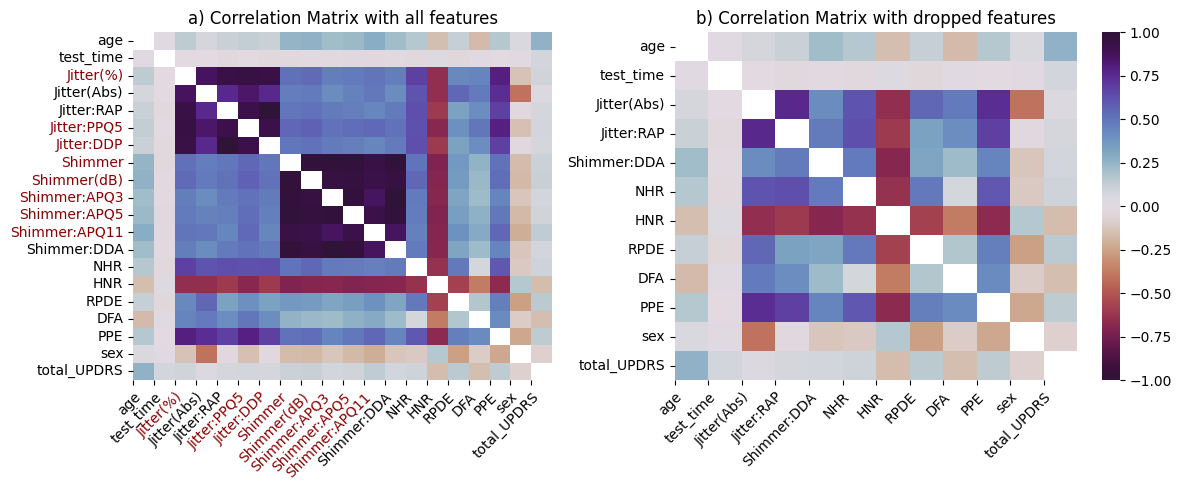

In [99]:
### Plot correlation matrices before and after cleaning ###

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=False, gridspec_kw={'width_ratios': [1, 1.2]})
sns.heatmap(parkcorr, cmap='twilight_shifted_r', cbar=False, ax=axes[0], vmin=-1, vmax=1)
sns.heatmap(parkcorr_temp, cmap='twilight_shifted_r', ax=axes[1], vmin=-1, vmax=1);

# Setting axis labels
axes[0].set_xticks(range(len(parkcorr.columns)), labels=parkcorr.columns,
              rotation=45, ha="right", rotation_mode="anchor")
axes[1].set_xticks(range(len(parkcorr_temp.columns)), labels=parkcorr_temp.columns,
              rotation=45, ha="right", rotation_mode="anchor")

# Color coding labels (red=dropped features)
for label in axes[0].get_xticklabels() + axes[0].get_yticklabels():
    if label.get_text()=="total_UPDRS" or label.get_text() in kept_features:
        label.set_color("black")
    else:
      label.set_color("darkred")

# Titles
axes[0].set_title("a) Correlation Matrix with all features")
axes[1].set_title("b) Correlation Matrix with dropped features")

fig.tight_layout()
plt.savefig("./figures/data1_corr.png", bbox_inches='tight', dpi=300)
plt.show()

In [100]:
### Final cleaned dataframe ###
# combining the target and features into one dataframe
parkdf_c = parkdfnorm.drop(columns=dropped_features)
# removing test_time & sex
parkdf_c = parkdf_c.drop(columns=['test_time', 'sex'])
parkdf_c

,age,Jitter(Abs),Jitter:RAP,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE,motor_UPDRS,total_UPDRS
0,0.835102,-0.100980,1.652566,0.071274,-0.403685,-0.296035,-1.160303,-1.466151,-0.586582,0.846457,0.488537
1,0.835102,-0.986336,-0.941829,-0.592042,-0.663687,1.424871,-0.987775,-1.230238,-1.356277,0.876790,0.534501
2,0.835102,-0.580114,-0.237774,-0.980470,0.081466,0.140789,-0.694424,-1.529206,0.155264,0.907124,0.580372
3,0.835102,-0.475954,-0.372798,-0.425217,0.704637,0.574818,-0.424830,-1.040208,1.971808,0.932809,0.619385
4,0.835102,-0.814473,-1.317969,-1.063136,-0.621717,1.096709,-0.590585,-1.281460,-0.089599,0.967301,0.671742
...,...,...,...,...,...,...,...,...,...,...,...
4949,-0.531424,-0.241596,-0.604269,-0.622917,0.483741,-0.069706,1.239712,-1.398047,0.207554,0.147562,0.403931
4950,-0.531424,-0.574906,-1.067209,-0.504894,-0.597009,0.090804,-0.009044,-1.224322,-1.088009,0.086773,0.357875
4951,-0.531424,-0.574906,-0.748938,-0.029319,-0.124621,0.767306,-0.525659,-1.026645,-0.860478,0.026473,0.312190
4952,-0.531424,-0.804057,-0.980408,-1.042220,-0.919598,0.567678,0.449633,-1.251881,-0.853516,-0.033216,0.266968


#### Statistics

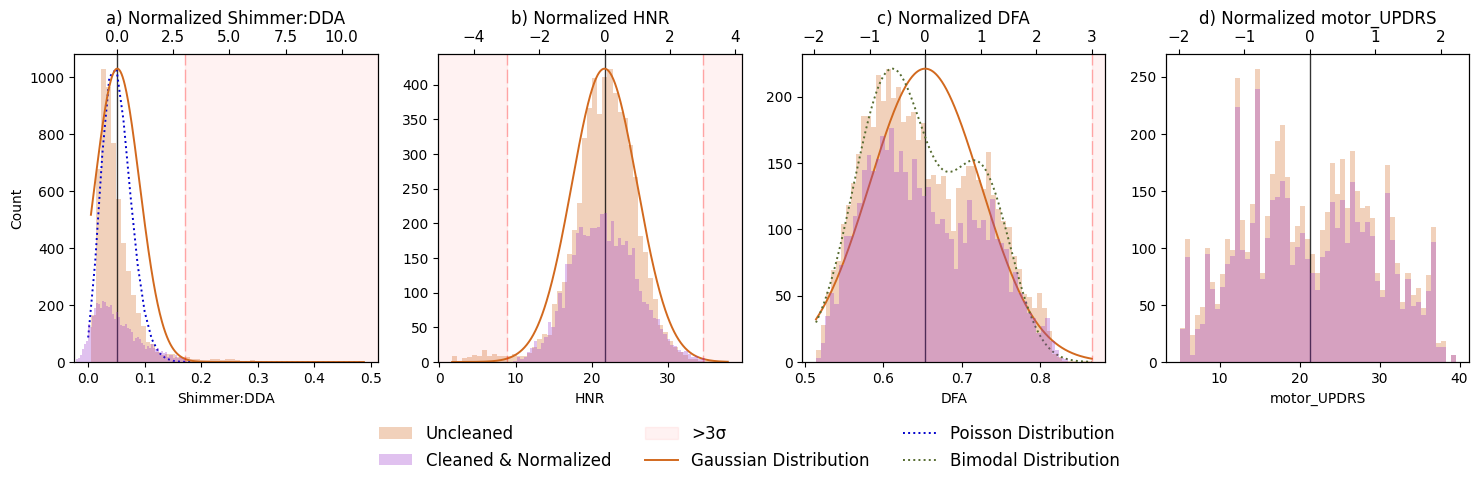

In [101]:
### Plot distributions of selected features & target before and after cleaning ###

fig, axes = plt.subplots(1, 4, figsize=(18, 4), sharey=False)
all_handles = []
all_labels = []

# features used in example
parkdf_stats_raw = parkdf[["Shimmer:DDA", "HNR", "DFA", "motor_UPDRS" ]]
parkdf_stats_clean = parkdfnorm[["Shimmer:DDA", "HNR", "DFA", "motor_UPDRS" ]]
label_letters = ['a)', 'b)', 'c)', 'd)']

# function definitions:
def poisson(x, mu):
  return np.array([mu**k * np.exp(-mu) / factorial(int(k)) for k in x])

def gaussian(x, mu, sigma):
  return (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-(x - mu)**2 / (2 * sigma**2))

def bimodal(x, mu1, sigma1, mu2, sigma2, ratio=0.5):
    return ratio * gaussian(x, mu1, sigma1) + (1 - ratio) * gaussian(x, mu2, sigma2)

for index, c1 in enumerate(parkdf_stats_raw.columns):
    # set up
    raw = parkdf_stats_raw[c1]
    clean = parkdf_stats_clean[c1]
    mean = raw.mean()
    std = raw.std()
    bin = 55

    # seperate the two sides
    inside_mask = (raw >= mean - 3*std) & (raw <= mean + 3*std)
    outside_mask = ~inside_mask

    # raw data
    sns.histplot(raw, ax=axes[index], bins=bin, color='chocolate', alpha=.3, 
                 label='Uncleaned', kde=False, linestyle="-", element="step", 
                 edgecolor=None, line_kws={'alpha': .35, 'linewidth' : 0.8}
                 )
    counts, bin_edges = np.histogram(raw, bins=bin) # for the gaussian plot

    # cleaned data
    ax_top = axes[index].twiny()
    sns.histplot(clean, kde=False, label='Cleaned & Normalized', bins=bin, ax=ax_top,  
                 color='darkorchid', alpha=.3, edgecolor=None, element="step", 
                 line_kws={'alpha': .35, 'linewidth' :0.8}
                 )
    axes[index].axvline(x=mean, color='b', linewidth=0.99, alpha=.8, label=f"Mean: {mean:.2f}", c="black")
    ax_top.set_xlabel(f"{label_letters[index]} Normalized {c1}", fontsize=12, color='black')
    ax_top.tick_params(labelsize=11, color='black', labelcolor='black')

    # fixing the normalized axis + adding distributions
    x = np.linspace(raw.min(), raw.max(), 500)
    if index == 0:

      # normalized axis
      scale_factor = 80
      raw_scaled = np.round(raw * scale_factor)
      mean_scaled = raw_scaled.mean()
      std_scaled = raw_scaled.std()
      ax_top.set_xlim((axes[index].get_xlim()[0] * scale_factor - mean_scaled) / std_scaled, 
                      (axes[index].get_xlim()[1] * scale_factor - mean_scaled) / std_scaled
                      )

      # poisson dist
      x_scaled = np.arange(raw_scaled.min(), raw_scaled.max() + 1)
      y_poiss = poisson(x_scaled, mean_scaled)
      y = y_poiss * max(counts) / max(y_poiss)
      x_original = x_scaled / scale_factor
      axes[index].plot(x_original, y, color='mediumblue', linestyle=':', linewidth=1.4, label='Poisson Distribution')

    if index in {0, 1, 2}:
      # normalized axis
      ax_top.set_xlim((axes[index].get_xlim()[0] - mean) / std,(axes[index].get_xlim()[1] - mean) / std)

      # gaussian dist
      x = np.linspace(raw.min(), raw.max(), 500)
      y_gauss = gaussian(x, mean, std)
      y = y_gauss * max(counts) / max(y_gauss)
      axes[index].plot(x, y, color='chocolate', linestyle='-', linewidth=1.4, label='Gaussian Distribution')

    if index == 2:
      #binomial dist
      x = np.linspace(raw.min(), raw.max(), 500)
      y_gauss = bimodal(x, 0.61,  0.048, 0.725, 0.038, ratio=.67)
      y = y_gauss * max(counts) / max(y_gauss)
      axes[index].plot(x, y, color='darkolivegreen', linestyle=':', linewidth=1.4, label='Bimodal Distribution')

    # >3σ cuts
    axes[index].set_ylim(axes[index].get_ylim())
    axes[index].set_xlim(axes[index].get_xlim())
    axes[index].axvline(x=mean+3*std, color='r', linestyle=(5, (10, 3)), linewidth=0.99, alpha=.3)
    axes[index].axvline(x=mean-3*std, color='r', linestyle=(5, (10, 3)), linewidth=0.99, alpha=.3)
    axes[index].fill_betweenx(axes[index].get_ylim(),axes[index].get_xlim()[0], mean - 3*std, color='r', alpha=.05, label='>3σ')
    axes[index].fill_betweenx(axes[index].get_ylim(), mean + 3*std ,axes[index].get_xlim()[1], color='r', alpha=.05)

   # labels & legend
    handles, labels = axes[index].get_legend_handles_labels()
    for h, l in zip(handles, labels):
        if h not in all_handles:
            all_handles.append(h)
            all_labels.append(l)
    handles_top, labels_top = ax_top.get_legend_handles_labels()
    for h, l in zip(handles_top, labels_top):
        if h not in all_handles:
            all_handles.append(h)
            all_labels.append(l)
    if index != 0:
        axes[index].set_ylabel("")  # hide y-axis labels for all but the first subplot


# getting the right order
handle_dict = dict(zip(all_labels, all_handles))
legend_order = ["Uncleaned", "Cleaned & Normalized", ">3σ", "Gaussian Distribution", "Poisson Distribution", "Bimodal Distribution"]
fig.legend([handle_dict[l] for l in legend_order if l in handle_dict],
           [l for l in legend_order if l in handle_dict],
           loc='upper center', bbox_to_anchor=(0.5, -0.01),
           ncol=3, fontsize=12, frameon=False)

plt.savefig("./figures/data1_dist.png", bbox_inches='tight', dpi=300)
plt.show()

### Run experiments

#### 1. 80/20 train/test split

In [102]:
### Splitting the data into training and testing sets ###
test_split = 0.2  # for 80/20 train/test split
park_test = parkdf_c.sample(frac=test_split).reset_index(drop=True)  # random test set
park_train = parkdf_c.drop(park_test.index).reset_index(drop=True)  # training set

# Define target and features for both sets
y_train = park_train["motor_UPDRS"]
x_train = park_train.drop(columns=["motor_UPDRS"])
y_test = park_test["motor_UPDRS"]
x_test = park_test.drop(columns=["motor_UPDRS"])

In [105]:
### Run Analytical Linear Regression ###
# Train linear model on the full training set
lin_model_analytical = LinearRegression()
yh_analytical = lin_model_analytical.fit_analytical(x_train,y_train).predict(x_train)

# Print optimal weights
# print(f'Features: {x_train.columns}')
# print(lin_model_analytical)

df = pd.DataFrame({'Feature': x_train.columns, 'Weight': lin_model_analytical.w[:-1]})
print(df.sort_values(by='Weight', key=abs, ascending=False))

# Test linear model
yh_test = lin_model_analytical.predict(x_test)

# Store metrics
lin_analytical_df = pd.DataFrame()
lin_analytical_df = store_lin_metrics(lin_analytical_df, 'analytical', y_train, yh_analytical, 
                                  y_test, yh_test, test_split, train_loss=lin_model_analytical.loss,
                                  model='linear'
                                  )
lin_analytical_df

       Feature    Weight
9  total_UPDRS  0.948630
1  Jitter(Abs) -0.195526
2   Jitter:RAP  0.079019
8          PPE  0.059908
4          NHR  0.038977
0          age -0.033277
7          DFA  0.031849
6         RPDE  0.016012
3  Shimmer:DDA -0.012342
5          HNR  0.008709


,method,train_RMSE,train_MAE,train_R2,test_RMSE,test_MAE,test_R2,test_split,train_split,test_loss,train_loss,iteration,num_batches,learning_rate,total_epochs
0,analytical,0.318515,0.242964,0.900011,0.314209,0.244907,0.89928,0.2,0.8,0.098727,0.101452,None,None,None,None


In [106]:
### Run Mini-Batch Gradient Descent Linear Regression ###
# Model
lin_model_gd = LinearRegression()  # new model for GD weights
optimizer = GradientDescent(learning_rate=.001, epsilon=1e-3, max_iters=1200, record_history=True)

# Train linear model on the full training set
num_batches = 8
yh_gd = lin_model_gd.fit_gd_minibatch(x_train, y_train, optimizer, num_batches=num_batches).predict(x_train)

# Print optimal weights
# print(f'Features: {x_train.columns}')
# print(lin_model_gd)

df = pd.DataFrame({'Feature': x_train.columns, 'Weight': lin_model_gd.w[:-1]})
print(df.sort_values(by='Weight', key=abs, ascending=False))

# Test linear model
yh_test_gd = lin_model_gd.predict(x_test)

# Store metrics
lin_gd_df = pd.DataFrame()
lin_gd_df = store_lin_metrics(lin_gd_df, 'minibatch GD', y_train, yh_gd, 
                                  y_test, yh_test_gd, test_split, train_loss=lin_model_gd.loss,
                                  model='linear'
                                  )
lin_gd_df

       Feature    Weight
9  total_UPDRS  0.945390
1  Jitter(Abs) -0.164234
2   Jitter:RAP  0.065801
8          PPE  0.052504
0          age -0.031260
4          NHR  0.027097
3  Shimmer:DDA -0.018702
7          DFA  0.018201
5          HNR -0.011517
6         RPDE  0.004706


,method,train_RMSE,train_MAE,train_R2,test_RMSE,test_MAE,test_R2,test_split,train_split,test_loss,train_loss,iteration,num_batches,learning_rate,total_epochs
0,minibatch GD,0.319092,0.243337,0.899649,0.313958,0.244073,0.899441,0.2,0.8,0.098569,0.101819,None,None,None,None


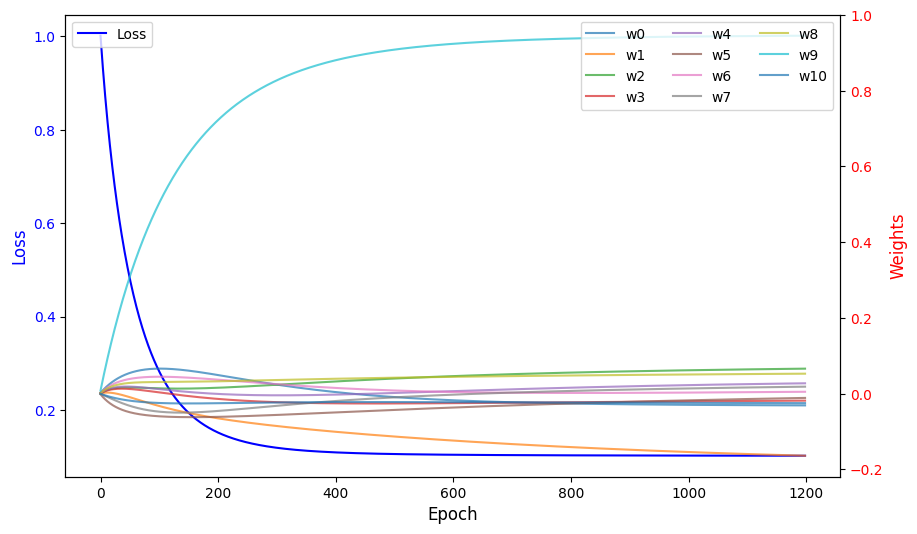

In [107]:
# Plot history of loss and weights for GD
plot_history(lin_model_gd)

#### 2. Sample growing subsets of the training data

In [108]:
### Training on 20%-80% of the full training set ###
train_split_range = np.arange(0.2, 0.81, 0.1)
lin_splits_df = pd.DataFrame()  # dataframe to store all metrics (for both methods)
iterations = 16  # number of iterations for each train split (to average out randomness)

# go through different splits
for train_split in train_split_range:
  for i in range(iterations):
    # Random training subset
    park_train_temp = park_train.sample(frac=train_split).reset_index(drop=True)
    y_train = park_train_temp["motor_UPDRS"]
    x_train = park_train_temp.drop(columns=["motor_UPDRS"])

    # ANALYTICAL MODEL
    lin_model_analytical_splits = LinearRegression()
    yh_analytical_train = lin_model_analytical_splits.fit_analytical(x_train, y_train).predict(x_train)
    yh_analytical_test = lin_model_analytical_splits.predict(x_test)
    lin_splits_df = store_lin_metrics(lin_splits_df, 'analytical', 
                                             y_train, yh_analytical_train, y_test, 
                                             yh_analytical_test, 0.2, round(train_split*0.8,1), 
                                             i, train_loss=lin_model_analytical.loss, model='linear'
                                             )

    # GRADIENT MODEL MINI-BATCH
    lin_model_gd_splits = LinearRegression()
    optimizer = GradientDescent(learning_rate=.001, min_delta_loss=5e-6, max_iters=10000, epsilon=1e-3, record_history=False)
    yh_gd_train = lin_model_gd_splits.fit_gd_minibatch(x_train, y_train, optimizer).predict(x_train)
    yh_gd_test = lin_model_gd_splits.predict(x_test)
    lin_splits_df = store_lin_metrics(lin_splits_df, 'mini-batch', y_train, 
                                             yh_gd_train, y_test, yh_gd_test, 0.2, round(train_split*0.8,1), 
                                             iteration=i, train_loss=lin_model_gd.loss, num_batches=lin_model_gd.num_batches, 
                                             total_epochs=lin_model_gd.total_epochs, model='linear'
                                             )

In [109]:
lin_splits_df

,method,train_RMSE,train_MAE,train_R2,test_RMSE,test_MAE,test_R2,test_split,train_split,test_loss,train_loss,iteration,num_batches,learning_rate,total_epochs
0,analytical,0.320174,0.245295,0.899657,0.314748,0.244201,0.898934,0.2,0.2,0.099067,0.101452,0,None,None,None
1,mini-batch,0.322938,0.246903,0.897917,0.314498,0.242944,0.899095,0.2,0.2,0.098909,0.101819,0,8,None,1200
2,analytical,0.327245,0.248212,0.896593,0.315240,0.245160,0.898618,0.2,0.2,0.099376,0.101452,1,None,None,None
3,mini-batch,0.329386,0.249357,0.895236,0.317338,0.245592,0.897264,0.2,0.2,0.100703,0.101819,1,8,None,1200
4,analytical,0.331227,0.255026,0.889370,0.315031,0.246434,0.898752,0.2,0.2,0.099245,0.101452,2,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219,mini-batch,0.319806,0.244622,0.899942,0.315247,0.244278,0.898613,0.2,0.6,0.099381,0.101819,13,8,None,1200
220,analytical,0.319324,0.243576,0.898274,0.314242,0.245129,0.899259,0.2,0.6,0.098748,0.101452,14,None,None,None
221,mini-batch,0.321656,0.245688,0.896783,0.315361,0.244548,0.898540,0.2,0.6,0.099452,0.101819,14,8,None,1200
222,analytical,0.315716,0.240501,0.900437,0.314162,0.244556,0.899310,0.2,0.6,0.098698,0.101452,15,None,None,None


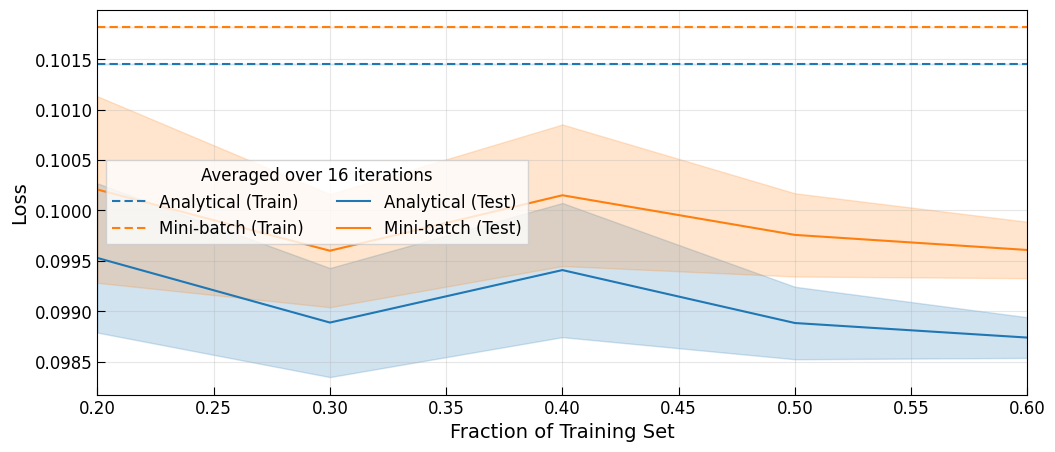

In [110]:
### Plot Average Loss ###
fig, ax = plt.subplots(figsize=(12,5))

# plot train and test loss for both methods
sns.lineplot(ax=ax,
             data=lin_splits_df,
             x="train_split",  # group by train split
             y="train_loss",
             hue='method',
             style='method',
             dashes=[(4,2), (4,2)],
             legend=True,
             errorbar='sd' # stdev to show the variability of loss between iterations
             )
sns.lineplot(ax=ax,
             data=lin_splits_df,
             x="train_split",  # group by train split
             y="test_loss",
             hue='method',
             legend=True,
             errorbar='sd' # stdev to show the variability of loss between iterations
             )

# Legend
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles, [
    "Analytical (Train)",   # first dashed line = analytical train
    "Mini-batch (Train)",   # second dashed line = mini-batch train
    "Analytical (Test)",    # first solid line = analytical test
    "Mini-batch (Test)"     # second solid line = mini-batch test
    ],
    fontsize=12, ncols=2, fancybox=False,
    title=f"Averaged over {iterations} iterations", title_fontsize=12
)

# Formatting
ax.grid(alpha=.3)
ax.set_xlabel("Fraction of Training Set", fontsize=14)
ax.set_ylabel("Loss", fontsize=14)
ax.tick_params(labelsize=12, direction='in', length=6)
ax.set_xlim(.2, .6)

plt.savefig("./figures/linreg_splits.png", bbox_inches='tight', dpi=300)
plt.show()

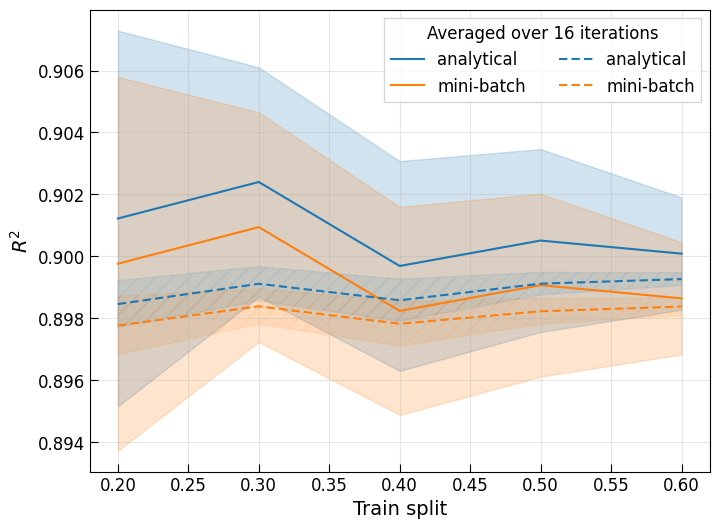

In [111]:
### Plot Average R^2 ###
fig, ax = plt.subplots(figsize=(8,6))

sns.lineplot(ax=ax,
             data=lin_splits_df,
             x="train_split",
             y="train_R2",
             hue='method',
             errorbar='sd' # stdev to show the variability of loss between iterations
             )

sns.lineplot(ax=ax,
             data=lin_splits_df,
             x="train_split",
             y="test_R2",
             hue='method',
             style='method',
             dashes={'analytical': (4,2), 'mini-batch': (4,2)},
             errorbar='sd'# stdev to show the variability of loss between iterations
             )

# Apply hatches to the error bands
for collection in ax.collections[2:]:
  collection.set_hatch('//')
  collection.set_alpha(0.1)   # keep it transparent so hatch is visible

ax.grid(alpha=.3)
ax.set_xlabel("Train split", fontsize=14)
ax.set_ylabel("$R^2$", fontsize=14)
ax.tick_params(labelsize=12, direction='in', length=6)
ax.legend(loc='best', fontsize=12, ncols=2, fancybox=False, 
          title=f"Averaged over {iterations} iterations", title_fontsize=12)
plt.show()

#### 3. Varying mini-batch size

In [112]:
### Varying number of mini-batches ###
num_batches = [8, 16, 32, 64, 128]  # number of batches to try
iterations = 16  # averaging results over multiple iterations
lin_batch_df = pd.DataFrame()  # dataframe to store all metrics (for both methods)
avg_weights = []  # store average weights for each batch

# go through different batch sizes
for n_batch in num_batches:
    avg_weights_batch = []  # store weights for averaging
    for i in range(iterations):
        # Define the GD model
        lin_model_gd = LinearRegression()
        optimizer = GradientDescent(learning_rate=.001, epsilon=1e-3, max_iters=10000, record_history=True)
        
        # Train linear model on the full training set
        yh_gd = lin_model_gd.fit_gd_minibatch(x_train, y_train, optimizer, n_batch).predict(x_train)
        yh_test_gd = lin_model_gd.predict(x_test)
        lin_batch_df = store_lin_metrics(lin_batch_df, 'mini-batch', y_train, yh_gd, y_test, 
                                        yh_test_gd, test_split=0.2, train_split=0.8, 
                                        iteration=i, num_batches=n_batch, train_loss=lin_model_gd.loss, 
                                        total_epochs=lin_model_gd.total_epochs, model='linear'
                                        )
        # add optimal weights
        avg_weights_batch.append(lin_model_gd.w)
    # average weights over iterations & store
    avg_weights.append(np.mean(np.array(avg_weights_batch), axis=0))

In [113]:
### Print averaged weights for each batch size ###
# Create DataFrame
avg_weights_array = np.array(avg_weights)
columns = list(x_train.columns) + ['bias']
weights_table = pd.DataFrame(
    data=avg_weights_array,
    columns=columns,
    index=num_batches
)
weights_table.index.name = "num_batches"

# Print as table
print("Average weights (including bias) for each mini-batch setting:\n")
print(weights_table.round(4))

Average weights (including bias) for each mini-batch setting:

                age  Jitter(Abs)  Jitter:RAP  Shimmer:DDA     NHR     HNR  \
num_batches                                                                 
8           -0.0275      -0.1603      0.0669      -0.0209  0.0283 -0.0124   
16          -0.0284      -0.1688      0.0707      -0.0189  0.0323 -0.0063   
32          -0.0288      -0.1749      0.0735      -0.0175  0.0349 -0.0019   
64          -0.0290      -0.1791      0.0753      -0.0165  0.0366  0.0011   
128         -0.0291      -0.1807      0.0760      -0.0161  0.0371  0.0022   

               RPDE     DFA     PPE  total_UPDRS    bias  
num_batches                                               
8            0.0046  0.0225  0.0427       0.9486 -0.0209  
16           0.0074  0.0267  0.0442       0.9500 -0.0215  
32           0.0097  0.0297  0.0454       0.9508 -0.0218  
64           0.0114  0.0316  0.0462       0.9512 -0.0221  
128          0.0120  0.0323  0.0465       0

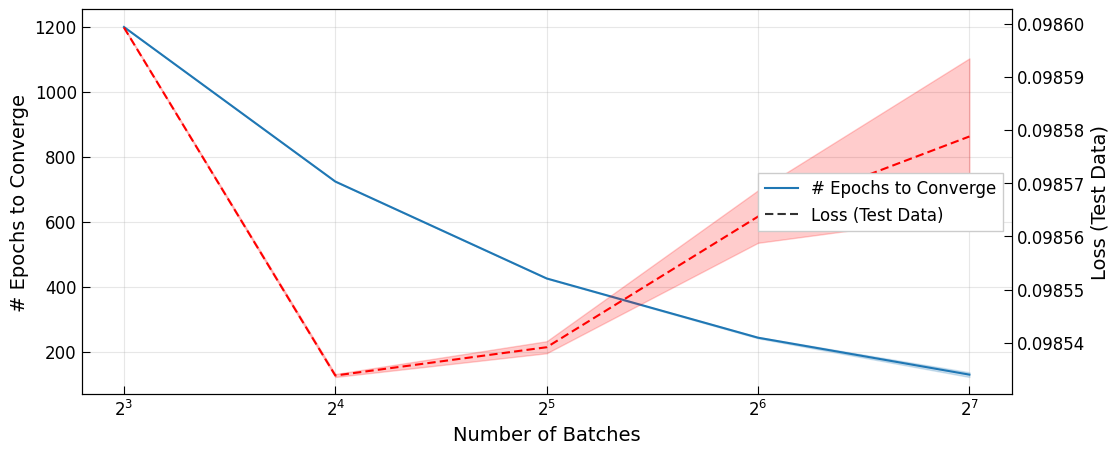

In [114]:
### Plot epochs to converge vs number of batches ###
fig, ax = plt.subplots(figsize=(12,5))

# Plot epochs to converge for different number of batches
sns.lineplot(ax=ax,
             data=lin_batch_df,
             x="num_batches",
             y="total_epochs",
             errorbar='sd',
             label=['total_epochs'],
             )

# Plot test loss on secondary y-axis
ax1 = ax.twinx()
sns.lineplot(ax=ax1,
             data=lin_batch_df,
             x="num_batches",
             y="test_loss",
             style='method',
             dashes={'mini-batch': (4,2)},
             errorbar='sd',
             color='r'
             )

# Legend
handles, _ = ax.get_legend_handles_labels()
handles1, _ = ax1.get_legend_handles_labels()
ax.legend().remove()
ax1.legend(handles + handles1, ['# Epochs to Converge', 'Loss (Test Data)'], 
           framealpha=1, loc='center right', fontsize=12, ncols=1, fancybox=False, 
           #title=f"Averaged over {iterations} iterations", 
           title_fontsize=12)

# Formatting
ax.tick_params(labelsize=12, direction='in', length=6)
ax1.tick_params(labelsize=12, direction='in', length=6)
ax.grid(alpha=.3)

# Labels & axes
ax.set_ylabel("# Epochs to Converge", fontsize=14)
ax1.set_ylabel("Loss (Test Data)", fontsize=14)
ax.set_xlabel('Number of Batches', fontsize=14)
ax.set_xscale('log', base=2)

plt.savefig("./figures/linreg_batches.png", bbox_inches='tight', dpi=300)
plt.show()

#### 4. Varying Learning Rate

In [177]:
### Varying Learning Rate ###
learning_rates = [0.001, 0.01, 0.4]  # learning rates to try
iterations = 16  # averaging results over multiple iterations
lin_rates_df = pd.DataFrame()  # dataframe to store all metrics (for both methods)

last_models = []  # store the last models for each learning rate

# go through different rates
for rate in learning_rates:
    for i in range(iterations):
        # Define the GD model
        lin_model_gd = LinearRegression()
        optimizer = GradientDescent(learning_rate=rate, epsilon=1e-3, min_delta_loss=5e-6, max_iters=1000, record_history=True)
        
        # Train linear model on the full training set
        yh_gd = lin_model_gd.fit_gd_minibatch(x_train, y_train, optimizer, num_batches=8).predict(x_train)
        yh_test_gd = lin_model_gd.predict(x_test)
        lin_rates_df = store_lin_metrics(lin_rates_df, 'mini-batch', y_train, yh_gd, y_test, 
                                        yh_test_gd, test_split=0.2, train_split=0.8, 
                                        iteration=i, num_batches=n_batch, train_loss=lin_model_gd.loss, 
                                        total_epochs=lin_model_gd.total_epochs, model='linear',
                                        learning_rate=rate
                                        )
        if i == iterations-1:
            last_models.append(lin_model_gd)

In [178]:
### Average over iteration ###
# Group metric by number of batches & average over iterations
metrics = ["train_loss", "test_loss", "train_R2", "test_R2"]
avg_metrics_df = lin_rates_df.groupby("learning_rate")[metrics].mean().reset_index()
avg_metrics_df[metrics] = avg_metrics_df[metrics].round(4)  # round for better display

print(avg_metrics_df)

   learning_rate  train_loss  test_loss  train_R2  test_R2
0          0.001      0.1011     0.0996    0.8990   0.8984
1          0.010      0.0999     0.0985    0.9003   0.8995
2          0.400      0.1022     0.1013    0.8979   0.8967


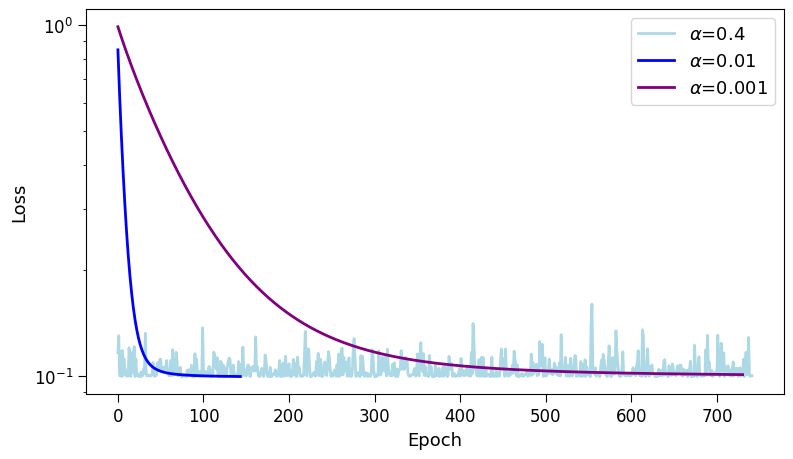

In [192]:
fig, ax = plt.subplots(figsize=(9,5))

plt.plot(last_models[2].loss_history, label=r'$\alpha$=0.4', lw=2, color='lightblue')
plt.plot(last_models[1].loss_history, label=r'$\alpha$=0.01', lw=2, color='blue')
plt.plot(last_models[0].loss_history, label=r'$\alpha$=0.001', lw=2, color='purple')

plt.xlabel('Epoch', fontsize=13)
plt.ylabel('Loss', fontsize=13)
plt.legend(fontsize=13)
plt.yscale('log', base=10)
plt.tick_params(labelsize=12, length=6)
# plt.xscale('log', base=2)

## Dataset 2: Breast Cancer Prediction

### Acquire, preprocess, and analyze the data

#### Load Data

In [69]:
# Fetch dataset
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17)
breastdata = breast_cancer_wisconsin_diagnostic.data

# Get features and targets (x and y)
breast_feat = breastdata.features
breast_targets = breastdata.targets

In [70]:
### NOTE: DECIDED NOT TO DO `OHE` FOR DIAGNOSIS TO AVOID DOING SOFTMAX... WE ARE WORKING WITH BINARY TARGET ANYWAY
breast_targets_mapped = breast_targets.copy()
breast_targets_mapped['Diagnosis'] = breast_targets_mapped['Diagnosis'].map({'B': 0, 'M': 1})
breast_targets_mapped.value_counts()

Diagnosis
0            357
1            212
Name: count, dtype: int64

#### Remove outliers and normalize the features

In [71]:
### Exclude outliers from each feature ###
breastdf = pd.concat([breast_targets_mapped, breast_feat], axis=1)
breastdf_cut = remove_outliers(breastdf,
                              z_threshold=3,
                              excl_cols=['Diagnosis']
                              )

========= REMOVING OUTLIERS =========
BEFORE -> N_data = 569
AFTER  -> N_data = 427


In [72]:
### Applying normalization  ###
breastdfnorm = znorm(breastdf_cut, excl_cols='Diagnosis')

#### Clean data based on correlations

In [73]:
### Get correlations for data ###
breast_corr = breastdfnorm.corr()
np.fill_diagonal(breast_corr.values, np.nan)

kept features:  ['Diagnosis', 'radius1', 'texture1', 'smoothness1', 'symmetry1', 'fractal_dimension1', 'radius2', 'texture2', 'smoothness2', 'concavity2', 'concave_points2', 'symmetry2', 'fractal_dimension2', 'smoothness3', 'compactness3', 'concave_points3', 'symmetry3', 'fractal_dimension3']


<Axes: >

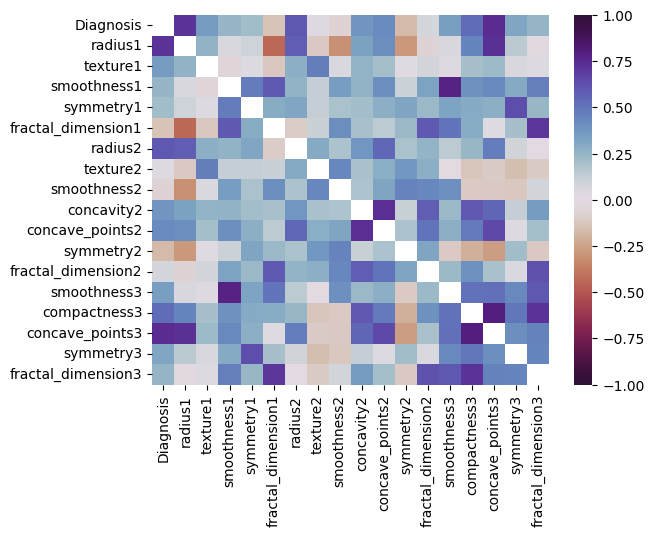

In [74]:
### Cleaning data based on correlations ###
# Part 1: Remove features that are too correlated with each other (threshold = 0.8)
breast_corr_temp = breast_corr.copy()

dropped_features = []
kept_features = []
while True:
  # 1. find highest abs(element), ignoring diagonals
  largest_element = breast_corr_temp.abs().max().max()
  if largest_element < 0.8: # MAX CORRELATION (to change if desired)
    break

  # 2. get both columns involved
  cols = breast_corr_temp.abs().stack()[breast_corr_temp.abs().stack() == largest_element].index[0]

  # 3. remove the one with greatest avg(corr) across the dataset
  corravg0 = breast_corr_temp[cols[0]].mean()
  corravg1 = breast_corr_temp[cols[1]].mean()

  if corravg0 > corravg1:
    breast_corr_temp = breast_corr_temp.drop(columns=cols[0])
    breast_corr_temp = breast_corr_temp.drop(index=cols[0])
    dropped_features.append(cols[0])
  else:
    breast_corr_temp = breast_corr_temp.drop(columns=cols[1])
    breast_corr_temp = breast_corr_temp.drop(index=cols[1])
    dropped_features.append(cols[1])

for col in breastdfnorm.columns:
  if col not in dropped_features:
    kept_features.append(col)

# Part 2: Remove features that are too uncorrelated with target (threshold = 0.3)
# implement?

print("kept features: ", kept_features)
sns.heatmap(breast_corr_temp, cmap='twilight_shifted_r', vmin=-1, vmax=1)

In [75]:
### Final cleaned dataframe ###
breastdf_c = breastdfnorm[kept_features]
breastdf_c

,Diagnosis,radius1,texture1,smoothness1,symmetry1,fractal_dimension1,radius2,texture2,smoothness2,concavity2,concave_points2,symmetry2,fractal_dimension2,smoothness3,compactness3,concave_points3,symmetry3,fractal_dimension3
0,1,2.567279,-0.210074,-0.751464,0.284188,-0.901234,1.396610,-0.891280,-0.601859,-0.360790,0.761256,-0.912555,0.388428,-0.260848,-0.201687,1.720038,-0.070887,0.851991
1,1,2.246832,0.676295,1.278988,1.458509,-0.244198,2.702372,-0.774151,-0.207599,1.000435,2.450405,0.646198,1.209026,0.777295,2.131121,2.826250,1.939110,0.729191
2,1,2.465318,-1.083708,0.519406,0.270480,-0.473765,2.777319,-0.786527,2.068455,2.281588,2.043410,-0.248139,1.638676,0.424528,-0.021259,1.263968,-0.969912,-0.191807
3,1,1.722465,0.352821,0.056306,0.201939,-0.752807,0.771188,-0.804428,-0.990152,-0.088821,0.053131,-0.948763,-0.680167,0.767216,0.494528,1.859770,0.658115,0.396609
4,1,0.069252,0.569320,2.038570,2.038816,2.629343,1.655049,0.529962,0.924035,0.072704,1.015334,-0.736946,1.873245,1.835596,1.579053,1.130058,0.967883,3.076031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
422,0,-1.223458,0.253487,0.519406,0.188231,0.412837,-0.537804,2.105682,2.673698,-1.356582,-0.725101,1.229146,-0.601977,-0.124781,-0.854755,-1.456538,-1.207479,-0.990005
423,0,0.389699,1.040522,-0.752281,-1.351638,0.048697,-0.658624,-0.064524,-1.020840,2.895934,1.387041,-0.461766,1.078710,-1.329229,1.077975,0.254792,-1.216795,0.086198
424,0,0.193061,2.179048,0.436914,-0.972382,0.096193,0.240097,0.784110,0.263809,-0.215141,1.434093,0.338430,1.787947,-0.245730,0.188585,0.144171,-1.235428,0.356528
425,1,2.407055,2.459222,0.315218,0.010027,-1.166423,2.830945,2.930007,-0.369991,1.081888,1.556427,0.008938,-0.428222,-0.623694,-0.146774,1.269790,-0.485463,-1.079547


#### Statistics

In [76]:
# ### Plot distributions of selected features & target before and after cleaning ###

# fig, axes = plt.subplots(1, 3, figsize=(18, 4), sharey=False)
# all_handles = []
# all_labels = []

# # features used in example
# parkdf_stats_raw = parkdf[["texture1", "radius2", "Diagnosis" ]]
# breastdf_clean = breastdf_c[["texture1", "HNR", "DFA", "Diagnosis"]]

# # function definitions:
# def poisson(x, mu):
#     return np.array([mu**k * np.exp(-mu) / factorial(int(k)) for k in x])

# def gaussian(x, mu, sigma):
#     return (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-(x - mu)**2 / (2 * sigma**2))

# def bimodal(x, mu1, sigma1, mu2, sigma2, ratio=0.5):
#         return ratio * gaussian(x, mu1, sigma1) + (1 - ratio) * gaussian(x, mu2, sigma2)

# for index, c1 in enumerate(parkdf_stats_raw.columns):
#         # set up
#         raw = parkdf_stats_raw[c1]
#         clean = parkdf_stats_clean[c1]
#         mean = raw.mean()
#         std = raw.std()
#         bin = 55

#         # seperate the two sides
#         inside_mask = (raw >= mean - 3*std) & (raw <= mean + 3*std)
#         outside_mask = ~inside_mask

#         # raw data
#         sns.histplot(raw, ax=axes[index], bins=bin, color='chocolate', alpha=.3, 
#                                  label='Uncleaned', kde=False, linestyle="-", element="step", 
#                                  edgecolor=None, line_kws={'alpha': .35, 'linewidth' : 0.8}
#                                  )
#         counts, bin_edges = np.histogram(raw, bins=bin) # for the gaussian plot

#         # cleaned data
#         ax_top = axes[index].twiny()
#         sns.histplot(clean, kde=False, label='Cleaned & Normalized', bins=bin, ax=ax_top,  
#                                  color='darkorchid', alpha=.3, edgecolor=None, element="step", 
#                                  line_kws={'alpha': .35, 'linewidth' :0.8}
#                                  )
#         axes[index].axvline(x=mean, color='b', linewidth=0.99, alpha=.8, label=f"Mean: {mean:.2f}", c="black")
#         ax_top.set_xlabel(f"Normalized {c1}", fontsize=12, color='black')
#         ax_top.tick_params(labelsize=11, color='black', labelcolor='black')

#         # fixing the normalized axis + adding distributions
#         x = np.linspace(raw.min(), raw.max(), 500)
#         if index == 0:

#             # normalized axis
#             scale_factor = 80
#             raw_scaled = np.round(raw * scale_factor)
#             mean_scaled = raw_scaled.mean()
#             std_scaled = raw_scaled.std()
#             ax_top.set_xlim((axes[index].get_xlim()[0] * scale_factor - mean_scaled) / std_scaled, 
#                                             (axes[index].get_xlim()[1] * scale_factor - mean_scaled) / std_scaled
#                                             )

#             # poisson dist
#             x_scaled = np.arange(raw_scaled.min(), raw_scaled.max() + 1)
#             y_poiss = poisson(x_scaled, mean_scaled)
#             y = y_poiss * max(counts) / max(y_poiss)
#             x_original = x_scaled / scale_factor
#             axes[index].plot(x_original, y, color='mediumblue', linestyle=':', linewidth=1.4, label='Poisson Distribution')

#         if index in {0, 1, 2}:
#             # normalized axis
#             ax_top.set_xlim((axes[index].get_xlim()[0] - mean) / std,(axes[index].get_xlim()[1] - mean) / std)

#             # gaussian dist
#             x = np.linspace(raw.min(), raw.max(), 500)
#             y_gauss = gaussian(x, mean, std)
#             y = y_gauss * max(counts) / max(y_gauss)
#             axes[index].plot(x, y, color='chocolate', linestyle='-', linewidth=1.4, label='Gaussian Distribution')

#         if index == 2:
#             #binomial dist
#             x = np.linspace(raw.min(), raw.max(), 500)
#             y_gauss = bimodal(x, 0.61,  0.048, 0.725, 0.038, ratio=.67)
#             y = y_gauss * max(counts) / max(y_gauss)
#             axes[index].plot(x, y, color='darkolivegreen', linestyle=':', linewidth=1.4, label='Bimodal Distribution')

#         # >3σ cuts
#         axes[index].set_ylim(axes[index].get_ylim())
#         axes[index].set_xlim(axes[index].get_xlim())
#         axes[index].axvline(x=mean+3*std, color='r', linestyle=(5, (10, 3)), linewidth=0.99, alpha=.3)
#         axes[index].axvline(x=mean-3*std, color='r', linestyle=(5, (10, 3)), linewidth=0.99, alpha=.3)
#         axes[index].fill_betweenx(axes[index].get_ylim(),axes[index].get_xlim()[0], mean - 3*std, color='r', alpha=.05, label='>3σ')
#         axes[index].fill_betweenx(axes[index].get_ylim(), mean + 3*std ,axes[index].get_xlim()[1], color='r', alpha=.05)

#      # labels & legend
#         handles, labels = axes[index].get_legend_handles_labels()
#         for h, l in zip(handles, labels):
#                 if h not in all_handles:
#                         all_handles.append(h)
#                         all_labels.append(l)
#         handles_top, labels_top = ax_top.get_legend_handles_labels()
#         for h, l in zip(handles_top, labels_top):
#                 if h not in all_handles:
#                         all_handles.append(h)
#                         all_labels.append(l)
        
#         if index != 0:
#                 axes[index].set_ylabel("")  # hide y-axis labels for all but the first subplot


# # getting the right order
# handle_dict = dict(zip(all_labels, all_handles))
# legend_order = ["Uncleaned", "Cleaned & Normalized", ">3σ", "Gaussian Distribution", "Poisson Distribution", "Bimodal Distribution"]
# fig.legend([handle_dict[l] for l in legend_order if l in handle_dict],
#                      [l for l in legend_order if l in handle_dict],
#                      loc='upper center', bbox_to_anchor=(0.5, -0.01),
#                      ncol=3, fontsize=12, frameon=False)
# plt.show()

### Run Experiments

#### 1. 80/20 train/test split

In [77]:
### Splitting the data into training and testing sets ###
test_split = 0.2 # 80/20 train/test split
breast_test = breastdf_c.sample(frac=test_split).reset_index(drop=True)
breast_train = breastdf_c.drop(breast_test.index).reset_index(drop=True)

# Define target and features for both sets
y_train = breast_train['Diagnosis']
x_train = breast_train.drop(columns=['Diagnosis'])
y_test = breast_test['Diagnosis']
x_test = breast_test.drop(columns=['Diagnosis'])

In [78]:
### Run a Full Batch Gradient Descent Logistic Regression ###
# Train linear model on the full training set
logist_model_full = LogisticRegression()
optimizer = GradientDescent(learning_rate=.001, min_delta_loss=5e-6, max_iters=10000, record_history=True)
yh_logistic = logist_model_full.fit_gd_fullbatch(x_train, y_train, optimizer).predict(x_train)

# Print optimal weights
print(f'Features: {x_train.columns}')
print(logist_model_full)

# Test linear model
yh_test = logist_model_full.predict(x_test)

# Store metrics
logistic_df = pd.DataFrame()
logistic_df = store_logist_metrics(logistic_df, 'full batch', y_train, yh_logistic, 
                                  y_test, yh_test, test_split=test_split, 
                                  train_loss=logist_model_full.loss, learning_rate=.001,
                                  model='logistic'
                                  )
logistic_df

Features: Index(['radius1', 'texture1', 'smoothness1', 'symmetry1', 'fractal_dimension1',
       'radius2', 'texture2', 'smoothness2', 'concavity2', 'concave_points2',
       'symmetry2', 'fractal_dimension2', 'smoothness3', 'compactness3',
       'concave_points3', 'symmetry3', 'fractal_dimension3'],
      dtype='object')
weights: [ 0.76845863  0.34092417  0.09100332  0.02532337 -0.29703473  0.69241302
  0.04858504 -0.05993388  0.13697331  0.09475514 -0.19380464 -0.13813687
  0.30598519  0.23587141  0.59534519  0.22670364  0.10141974 -1.23792306]


,method,train_accuracy,test_accuracy,test_split,train_split,test_R2,train_R2,test_loss,train_loss,iteration,learning_rate,total_epochs,num_batches
0,full batch,0.967836,0.929412,0.2,0.8,0.757303,0.770859,0.189785,0.165881,None,0.001,None,None


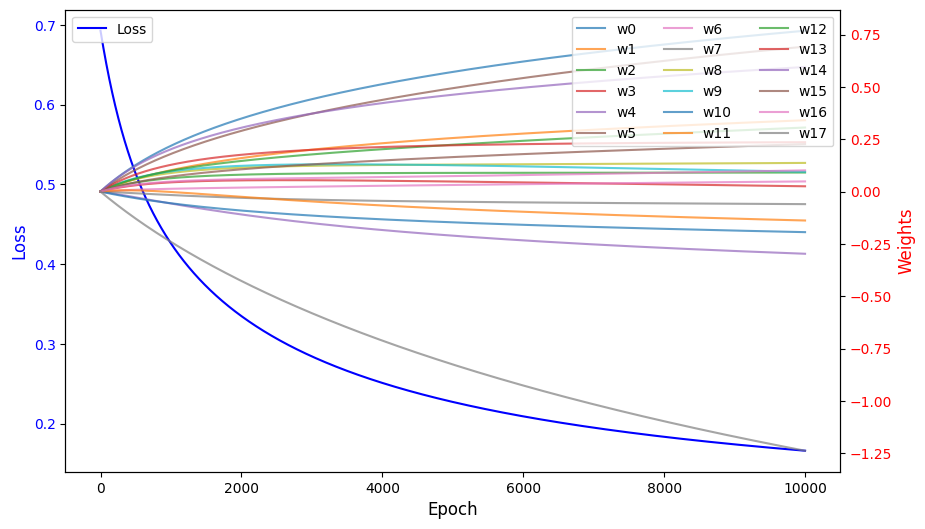

In [ ]:
# Plot history of loss and weights for GD
plot_history(optimizer)

#### 2. Sample growing subsets of the training data

In [79]:
### Training on 20%-80% of the full training set ###
train_split_range = np.arange(0.2, 0.81, 0.1)
logist_splits_df = pd.DataFrame()  # dataframe to store all metrics (for both methods)
iterations = 4  # number of iterations for each train split (to average out randomness)

# go through different splits
for train_split in train_split_range:
    for i in range(iterations):
        # Random training subset
        breast_train_temp = breast_train.sample(frac=train_split).reset_index(drop=True)
        y_train = breast_train_temp['Diagnosis']
        x_train = breast_train_temp.drop(columns=['Diagnosis'])

        # GRADIENT MODEL FULL BATCH
        logist_model_splits = LogisticRegression()
        optimizer = GradientDescent(learning_rate=.01, min_delta_loss=5e-6, max_iters=1000, record_history=False)
        yh_train = logist_model_splits.fit_gd_fullbatch(x_train, y_train, optimizer).predict(x_train)
        yh_test = logist_model_splits.predict(x_test)
        logist_splits_df = store_logist_metrics(logist_splits_df, 'full batch', y_train, 
                                                yh_train, y_test, yh_test, test_split=0.2, train_split=round(train_split*0.8,1), 
                                                iteration=i, train_loss=logist_model_splits.loss,
                                                model='logistic')

KeyboardInterrupt: 

In [80]:
# logist_splits_df

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_ol

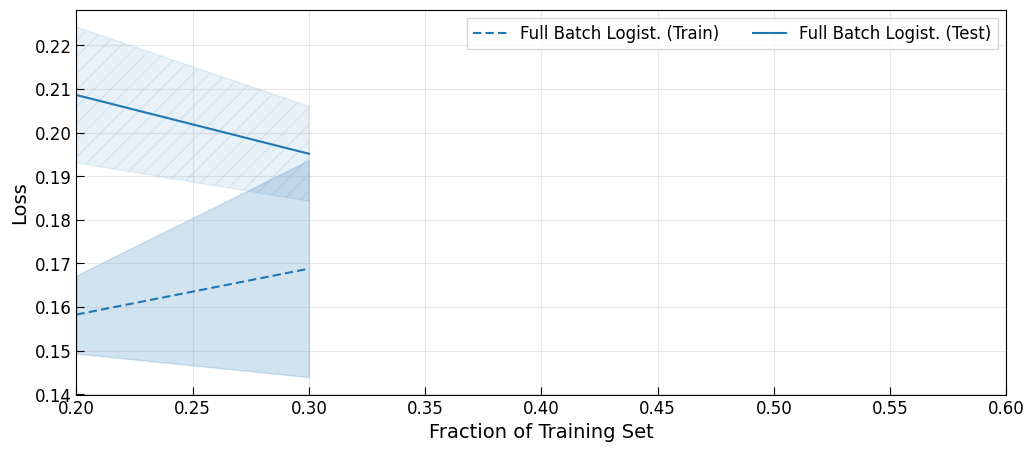

In [81]:
### Plot Average Loss ###
fig, ax = plt.subplots(figsize=(12,5))

# plot train and test loss for logistic method
sns.lineplot(ax=ax,
             data=logist_splits_df,
             x="train_split",  # group by train split
             y="train_loss",
             hue='method',
             style='method',
             dashes=[(4,2)],
             legend=True,
             errorbar='sd' # stdev to show the variability of loss between iterations
             )
sns.lineplot(ax=ax,
             data=logist_splits_df,
             x="train_split",  # group by train split
             y="test_loss",
             hue='method',
             legend=True,
             errorbar='sd' # stdev to show the variability of loss between iterations
             )

# Legend
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles, [
    "Full Batch Logist. (Train)",   # first dashed line = full batch train
    "Full Batch Logist. (Test)"     # first solid line = full batch test
    ],
    fontsize=12, ncols=2, fancybox=False,
    #title=f"Averaged over {iterations} iterations", title_fontsize=12
)

# Apply hatches to the error bands
for collection in ax.collections[1:]:
  collection.set_hatch('//')
  collection.set_alpha(0.1)   # keep it transparent so hatch is visible

# Formatting
ax.grid(alpha=.3)
ax.set_xlabel("Fraction of Training Set", fontsize=14)
ax.set_ylabel("Loss", fontsize=14)
ax.tick_params(labelsize=12, direction='in', length=6)
ax.set_xlim(.2, .6)

plt.savefig("./figures/logist_splits.png", bbox_inches='tight', dpi=300)
plt.show()

#### 3. Varying mini-batch size

In [82]:
### Varying number of mini-batches ###
num_batches = [8, 16, 32, 64, 128]  # number of batches to try
iterations = 16  # averaging results over multiple iterations
logist_batch_df = pd.DataFrame()  # dataframe to store all metrics
avg_weights = []  # store average weights for each batch

# go through different batch sizes
for n_batch in num_batches:
    avg_weights_batch = []  # store weights for averaging
    for i in range(iterations):
        # Define the GD model
        logist_model_batch = LogisticRegression()
        optimizer = GradientDescent(learning_rate=.01, min_delta_loss=5e-6, max_iters=10000, record_history=False)
        
        # Train linear model on the full training set
        yh_gd = logist_model_batch.fit_gd_minibatch(x_train, y_train, optimizer, n_batch).predict(x_train)
        yh_test_gd = logist_model_batch.predict(x_test)
        logist_batch_df = store_logist_metrics(logist_batch_df, 'mini-batch', y_train, yh_gd, y_test, 
                                        yh_test_gd, test_split=0.2, train_split=0.8, 
                                        iteration=i, num_batches=n_batch, train_loss=logist_model_batch.loss, 
                                        total_epochs=logist_model_batch.total_epochs, model='logistic'
                                        )
        # add optimal weights
        avg_weights_batch.append(logist_model_batch.w)
    # average weights over iterations & store
    avg_weights.append(np.mean(np.array(avg_weights_batch), axis=0))

In [83]:
### Print averaged weights for each batch size ###
# Create DataFrame
avg_weights_array = np.array(avg_weights)
columns = list(x_train.columns) + ['bias']
weights_table = pd.DataFrame(
    data=avg_weights_array,
    columns=columns,
    index=num_batches
)
weights_table.index.name = "num_batches"

# Print as table
print("Average weights (including bias) for each mini-batch setting:\n")
print(weights_table.round(4))

Average weights (including bias) for each mini-batch setting:

             radius1  texture1  smoothness1  symmetry1  fractal_dimension1  \
num_batches                                                                  
8             2.2704    0.9355       0.3592    -0.1261             -0.9806   
16            2.5540    1.1941       0.4547    -0.2499             -1.2040   
32            2.8092    1.5350       0.5388    -0.3967             -1.4318   
64            2.6113    1.2709       0.4755    -0.2840             -1.2551   
128           2.4271    1.0702       0.4077    -0.1930             -1.1026   

             radius2  texture2  smoothness2  concavity2  concave_points2  \
num_batches                                                                
8             1.9922    0.5393      -0.4764      0.6835          -0.9559   
16            2.4604    0.5991      -0.7386      0.9272          -1.2688   
32            3.0527    0.5977      -1.0399      1.2247          -1.6273   
64        

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_ol

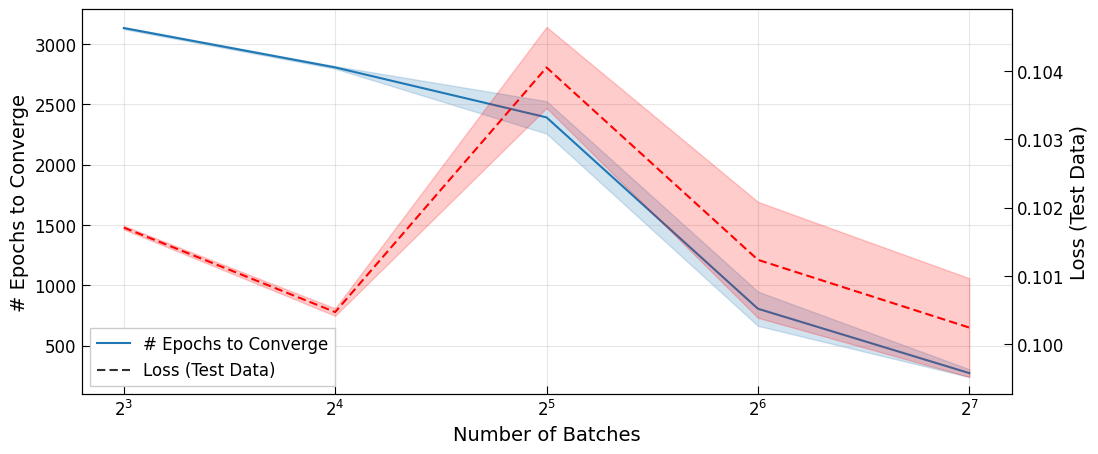

In [84]:
### Plot epochs to converge vs number of batches ###
fig, ax = plt.subplots(figsize=(12,5))

# Plot epochs to converge for different number of batches
sns.lineplot(ax=ax,
             data=logist_batch_df,
             x="num_batches",
             y="total_epochs",
             errorbar='sd',
             label=['total_epochs'],
             )

# Plot test loss on secondary y-axis
ax1 = ax.twinx()
sns.lineplot(ax=ax1,
             data=logist_batch_df,
             x="num_batches",
             y="test_loss",
             style='method',
             dashes={'mini-batch': (4,2)},
             errorbar='sd',
             color='r'
             )

# Legend
handles, _ = ax.get_legend_handles_labels()
handles1, _ = ax1.get_legend_handles_labels()
ax.legend().remove()
ax1.legend(handles + handles1, ['# Epochs to Converge', 'Loss (Test Data)'], 
           framealpha=1, loc='lower left', fontsize=12, ncols=1, fancybox=False, 
           #title=f"Averaged over {iterations} iterations", 
           title_fontsize=12)

# Formatting
ax.tick_params(labelsize=12, direction='in', length=6)
ax1.tick_params(labelsize=12, direction='in', length=6)
ax.grid(alpha=.3)

# Labels & axes
ax.set_ylabel("# Epochs to Converge", fontsize=14)
ax1.set_ylabel("Loss (Test Data)", fontsize=14)
ax.set_xlabel('Number of Batches', fontsize=14)
ax.set_xscale('log', base=2)

plt.savefig("./figures/logist_batches.png", bbox_inches='tight', dpi=300)
plt.show()

#### 4. Varying Learning Rate

In [86]:
### Varying Learning Rate ###
learning_rates = [0.001, 0.01, 0.4]  # learning rates to try
iterations = 16  # averaging results over multiple iterations
logist_rates_df = pd.DataFrame()  # dataframe to store all metrics (for both methods)

# go through different rates
for rate in learning_rates:
    for i in range(iterations):
        # Define the GD model
        logist_model_gd = LinearRegression()
        optimizer = GradientDescent(learning_rate=rate, min_delta_loss=5e-6, max_iters=1000, record_history=False)
        
        # Train linear model on the full training set
        yh_gd = logist_model_gd.fit_gd_minibatch(x_train, y_train, optimizer, num_batches=8).predict(x_train)
        yh_test_gd = logist_model_gd.predict(x_test)
        logist_rates_df = store_logist_metrics(logist_rates_df, 'mini-batch', y_train, yh_gd, y_test, 
                                        yh_test_gd, test_split=0.2, train_split=0.8, 
                                        iteration=i, num_batches=n_batch, train_loss=logist_model_gd.loss, 
                                        total_epochs=logist_model_gd.total_epochs, model='linear',
                                        learning_rate=rate
                                        )

In [87]:
### Average over iteration ###
# Group metric by number of batches & average over iterations
metrics = ["train_loss", "test_loss", "train_R2", "test_R2"]
avg_metrics_df = logist_rates_df.groupby("learning_rate")[metrics].mean().reset_index()
avg_metrics_df[metrics] = avg_metrics_df[metrics].round(4)  # round for better display

print(avg_metrics_df)

   learning_rate  train_loss  test_loss  train_R2  test_R2
0          0.001      0.0433     0.0681    0.7802   0.6641
1          0.010      0.0417     0.0685    0.7886   0.6621
2          0.400      0.8521     0.8993   -3.3223  -3.4380
